<a href="https://colab.research.google.com/github/Kathy42xu/UNdata_analysis/blob/main/Task1_and_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 1


In [31]:
import pandas as pd

excel_file = "/content/Task1_Analyze.xlsx"  # or your local path


# 1) Read the "Meta-POPLN" sheet to filter countries in East Asia & Pacific with "Lower middle income"
meta_df = pd.read_excel(excel_file, sheet_name="Meta-POPLN")


meta_filtered = meta_df[
    (meta_df["Region"] == "East Asia & Pacific") &
    (meta_df["IncomeGroup"] == "Lower middle income")
]

# 2) Read the "Data-POPLN" sheet to get the "Population, total" indicator and merge with meta_filtered

popln_df = pd.read_excel(excel_file, sheet_name="Data-POPLN")

popln_df = popln_df[popln_df["Indicator Name"] == "Population, total"]

# Merge with meta_filtered on "Country Code" to get only the countries matching the criteria
merged_popln = pd.merge(
    meta_filtered, popln_df,
    on="Country Code",
    how="inner"
)

# Extract the 2015 population from the "2015" column
merged_popln["Population_2015"] = merged_popln["2015"]


# 3) Select the top 10 countries based on the 2015 population
top10 = merged_popln.sort_values(by="Population_2015", ascending=False).head(10)


# 4) Read the "Data-HLTHEXPENDITURE" sheet and filter for the appropriate series

hlth_df = pd.read_excel(excel_file, sheet_name="Data-HLTHEXPNDITURE")

hlth_filtered = hlth_df[
    hlth_df["Series Name"] == "Domestic general government health expenditure (% of current health expenditure)"
].copy()

# 5) Merge top10 with the health expenditure data on "Country Code"
merged_hlth = pd.merge(
    top10,
    hlth_filtered,
    on="Country Code",
    how="inner",
    suffixes=("_popln", "_health")
)

# 6) Rename columns for years 2005 to 2015 from "2005 [YR2005]" to "Val_2005", etc.
years = range(2000, 2021)
for y in years:
    old_col = f"{y} [YR{y}]"
    new_col = f"Val_{y}"
    if old_col in merged_hlth.columns:
        merged_hlth.rename(columns={old_col: new_col}, inplace=True)


# 7) Calculate the year-over-year (YoY) percentage change for 2006–2015
#    YoY_year = (Val_year - Val_(year-1)) / Val_(year-1) * 100

for year in range(2006, 2016):
    cur_col = f"Val_{year}"
    prev_col = f"Val_{year - 1}"
    yoy_col = f"YoY_{year}"

    if cur_col in merged_hlth.columns and prev_col in merged_hlth.columns:
        # Calculate the YoY percentage change and force float type to enable rounding
        merged_hlth[yoy_col] = ((merged_hlth[cur_col].astype(float) - merged_hlth[prev_col].astype(float))
                                / merged_hlth[prev_col].astype(float) * 100).round(1)
    else:
        merged_hlth[yoy_col] = pd.NA


# 8) Create the final summary table: Country Name + YoY_2006 to YoY_2015
# Note: the country name from the population table is stored as "Country Name_popln"
output_cols = ["Country Name_popln"] + [f"YoY_{y}" for y in range(2006, 2016)]
summary_df = merged_hlth[output_cols].copy()
summary_df.rename(columns={"Country Name_popln": "Country Name"}, inplace=True)

summary_df.sort_values(by="Country Name", inplace=True)

print("\nAnnual Increase in Domestic General Government Health Expenditure (YoY %) "
      "for the Ten Most-Populated Lower Middle Income Countries in East Asia & Pacific\n"
      "Period: 2005–2015 (YoY from 2006–2015)\n")
print(summary_df.to_string(index=False))

# Save the final summary table to Excel
summary_df.to_excel("health_yoy_summary.xlsx", index=False)



Annual Increase in Domestic General Government Health Expenditure (YoY %) for the Ten Most-Populated Lower Middle Income Countries in East Asia & Pacific
Period: 2005–2015 (YoY from 2006–2015)

    Country Name  YoY_2006  YoY_2007  YoY_2008  YoY_2009  YoY_2010  YoY_2011  YoY_2012  YoY_2013  YoY_2014  YoY_2015
        Cambodia     -12.0      26.3     -21.6       3.4      22.8     -13.6      13.6       3.1      -7.4      17.3
       Indonesia       9.7      13.7      -2.3      -0.3     -32.6      -0.9      12.1       8.1      17.6      18.2
         Lao PDR     -19.4     -17.4       2.6      78.5     -37.4      -9.0      11.5      41.2       0.2      18.4
        Mongolia       9.8       6.4      -0.1      -1.5      -6.0      -9.1       2.2      -8.1       2.3      -0.4
         Myanmar      63.9     -15.9     -19.3       6.9      13.6      21.5      44.0       9.6      28.1      -9.1
Papua New Guinea       1.9       0.5       5.0      -5.7      -7.7       5.8       4.7      -3.1      -

#Task 2


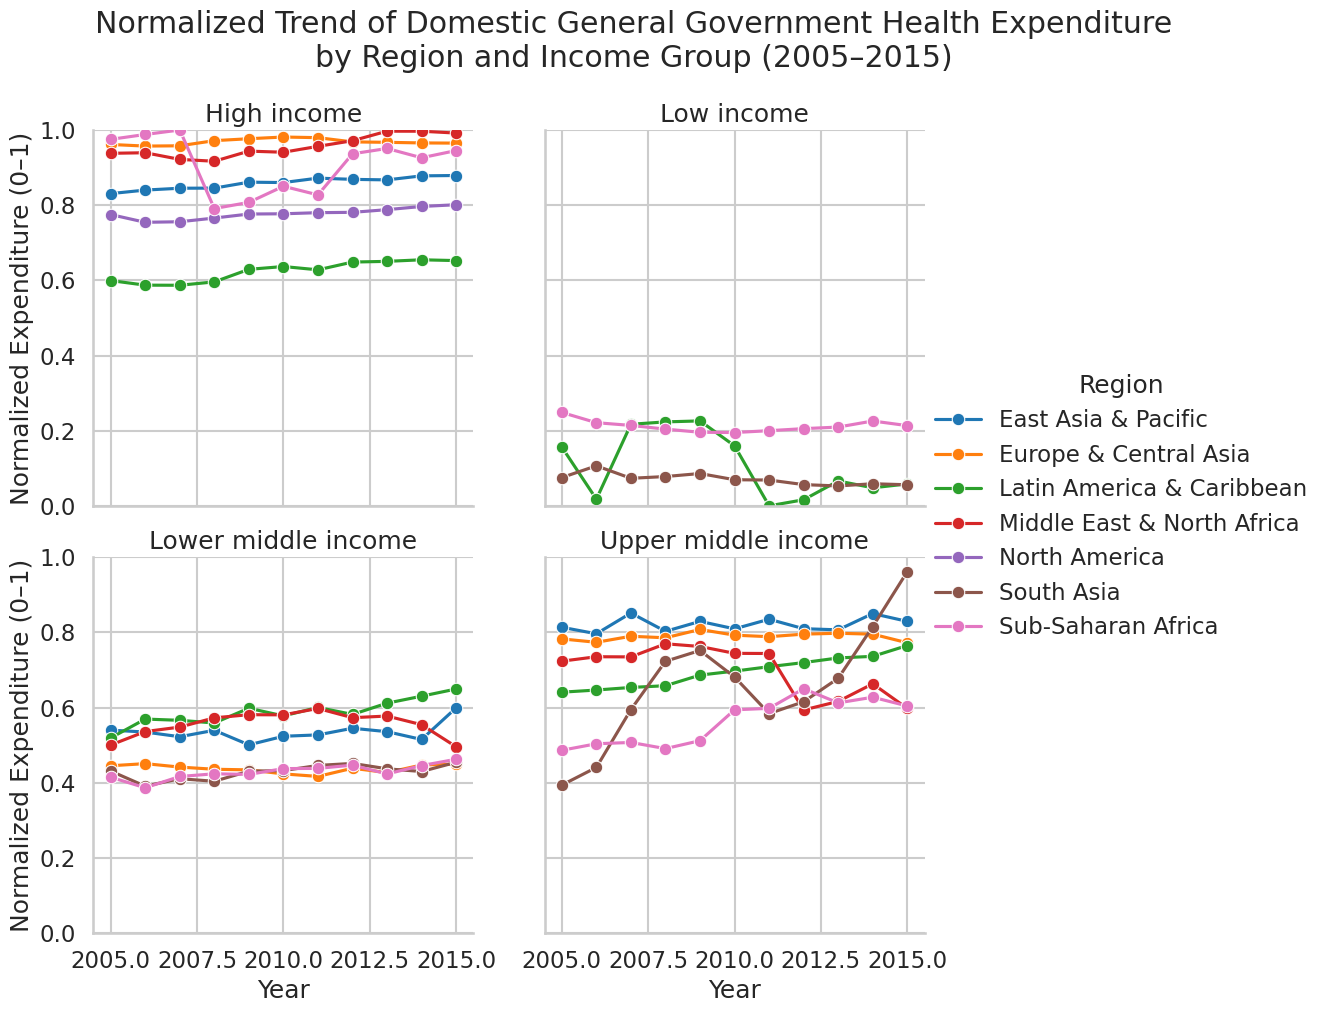

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


excel_file = "/content/Task1_Analyze.xlsx"  # Update to your local path if needed

# ------------------------------------------------------------------------------
# 1) Read the metadata and health expenditure sheets
# ------------------------------------------------------------------------------
meta_df = pd.read_excel(excel_file, sheet_name="Meta-POPLN")
hlth_df = pd.read_excel(excel_file, sheet_name="Data-HLTHEXPNDITURE")

# ------------------------------------------------------------------------------
# 2) Filter the health expenditure data for the desired series.
#    Adjust the Series Name if necessary.
# ------------------------------------------------------------------------------
hlth_filtered = hlth_df[
    hlth_df["Series Name"] == "Domestic general government health expenditure (% of current health expenditure)"
].copy()

# ------------------------------------------------------------------------------
# 3) Rename the year columns from e.g., "2005 [YR2005]" to "2005" for easier handling
# ------------------------------------------------------------------------------
def rename_year_col(col):
    if isinstance(col, str) and " [YR" in col:
        return col.split(" ")[0]
    else:
        return col

hlth_filtered = hlth_filtered.rename(columns=rename_year_col)

# ------------------------------------------------------------------------------
# 4) Merge the metadata with health expenditure data on "Country Code"
# ------------------------------------------------------------------------------
merged_df = pd.merge(meta_df, hlth_filtered, on="Country Code", how="inner")

# ------------------------------------------------------------------------------
# 5) Transform the data into a long format for years 2005-2015.
#    We assume these columns are now named as "2005", "2006", …, "2015".
# ------------------------------------------------------------------------------
years = [str(y) for y in range(2005, 2016)]
long_df = merged_df.melt(
    id_vars=["Country Code", "Region", "IncomeGroup", "Country Name"],
    value_vars=years,
    var_name="Year",
    value_name="Expenditure"
)
long_df["Year"] = long_df["Year"].astype(int)
long_df["Expenditure"] = pd.to_numeric(long_df["Expenditure"], errors="coerce")

# ------------------------------------------------------------------------------
# 6) Group the data by Region, IncomeGroup, and Year and calculate the average expenditure
# ------------------------------------------------------------------------------
grouped = long_df.groupby(["Region", "IncomeGroup", "Year"])["Expenditure"].mean().reset_index()

# ------------------------------------------------------------------------------
# 7) Normalize the Expenditure values (global normalization to the 0–1 range)
# ------------------------------------------------------------------------------
global_min = grouped["Expenditure"].min()
global_max = grouped["Expenditure"].max()
grouped["Expenditure_norm"] = (grouped["Expenditure"] - global_min) / (global_max - global_min)

# ------------------------------------------------------------------------------
# 8) Create a FacetGrid chart to display normalized expenditure trends by IncomeGroup
# ------------------------------------------------------------------------------
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.0)

g = sns.FacetGrid(
    data=grouped,
    col="IncomeGroup",
    hue="Region",
    col_wrap=2,
    height=5,
    sharey=True,
    legend_out=True
)
g.map(sns.lineplot, "Year", "Expenditure_norm", marker="o")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Year", "Normalized Expenditure (0–1)")
g.add_legend(title="Region")

# Ensure y-axis ranges from 0 to 1 in each subplot
for ax in g.axes:
    ax.set_ylim(0, 1)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Normalized Trend of Domestic General Government Health Expenditure\nby Region and Income Group (2005–2015)", y=1.02)

plt.show()


#Task 3


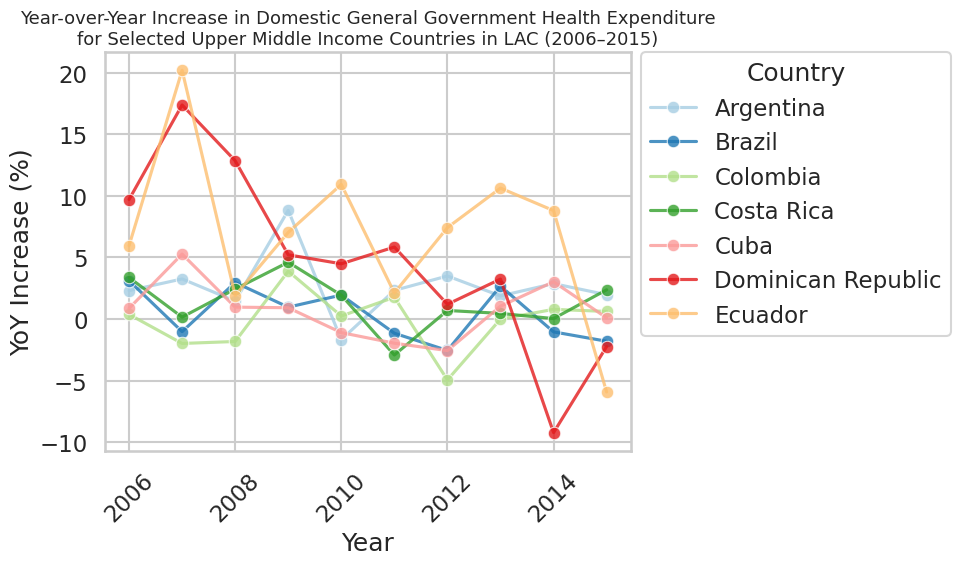

In [47]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


data = {
    "Country": [
        "Argentina",
        "Brazil",
        "Colombia",
        "Costa Rica",
        "Cuba",
        "Dominican Republic",
        "Ecuador"
    ],
    "2006": [2.30, 3.11, 0.37, 3.37, 0.86, 9.70, 5.95],
    "2007": [3.25, -1.03, -1.99, 0.15, 5.27, 17.38, 20.20],
    "2008": [1.45, 2.96, -1.83, 2.43, 0.96, 12.85, 1.90],
    "2009": [8.82, 0.96, 3.88, 4.61, 0.91, 5.21, 7.03],
    "2010": [-1.68, 1.94, 0.24, 1.93, -1.11, 4.48, 10.93],
    "2011": [2.32, -1.16, 1.76, -2.93, -1.97, 5.84, 2.11],
    "2012": [3.49, -2.56, -4.95, 0.69, -2.57, 1.19, 7.42],
    "2013": [1.87, 2.67, -0.01, 0.45, 1.04, 3.24, 10.63],
    "2014": [2.87, -1.05, 0.78, 0.03, 3.02, -9.23, 8.80],
    "2015": [1.97, -1.81, 0.61, 2.37, 0.09, -2.24, -5.93]
}

df = pd.DataFrame(data)


df_melted = df.melt(
    id_vars="Country",
    var_name="Year",
    value_name="YoY_Increase"
)


df_melted["Year"] = df_melted["Year"].astype(int)

# ---------------------------------------------------------
# 3) Create the figure and axes
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

# ---------------------------------------------------------
# 4) Plot the line chart
# ---------------------------------------------------------
# alpha=0.8 adds slight transparency, so overlapping lines remain visible
sns.lineplot(
    data=df_melted,
    x="Year",
    y="YoY_Increase",
    hue="Country",
    marker="o",
    alpha=0.8
)

# ---------------------------------------------------------
# 5) Title, axis labels, and legend adjustments
# ---------------------------------------------------------
plt.title(
    "Year-over-Year Increase in Domestic General Government Health Expenditure\n"
    "for Selected Upper Middle Income Countries in LAC (2006–2015)",
    fontsize=13
)
plt.xlabel("Year")
plt.ylabel("YoY Increase (%)")

# Move legend to the right side
plt.legend(title="Country", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

# ---------------------------------------------------------
# 6) Rotate x-ticks if needed (often helpful for many years)
# ---------------------------------------------------------
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
